# Tutorial 3: Atmospheric wind driven circulation

**Week 1, Day 2: State of the Climate - Ocean and Atmospheric Reanalysis**

__Content creators:__ Hell, Momme, Name Surname, Day Lead's Name

**Content reviewers:** Ohad Zivan and Will Gregory 

**Content editors:** Ohad Zivan and Chi Zhang

**Production editors:** 

**Our 2023 Sponsors:** NASA TOPS & Neuromatch

### Tutorial Objectives
NOTES: I used this intro is better suited for the next tutorial and here we should include some general intro for atmospheric large scale circulation


The ocean is driven by radiation from the sun, winds, and various sources of fresh water  (precipitation, rivers, melting and freezing ice). This tutorial focuses on the global atmospheric wind pattern and how these drive the large scale ocean current, i.e. the so called "wind driven circulation". The wind driven circulation is important for coastel communities and climates. It impacts the ocean temperature and upwelling systems along many coast lines and influences weather on many timescales. At the end of this tutorial you will be able to 

- Understand the seasonal changes of the surface winds
- compute seasonal climatologies and plot global maps.
- compare statistics of these climatologies.

For this tutorial we will use again the ERA5 dataset, first we will use some example data of 1-hour snapshots each day, and then we will use monthly means over the period of 30 years.

In [1]:
# @title Tutorial slides

# @markdown These are the slides for the videos in all tutorials today
from IPython.display import IFrame
#IFrame(src=f"path-to-video", width=854, height=480)

In [10]:
from intake import open_catalog
import matplotlib.pyplot as plt
import matplotlib
import os
import pooch
import boto3
import botocore
import numpy as np
import xarray as xr
import warnings
import datetime
from cartopy import crs as ccrs, feature as cfeature
#  Suppress warnings issued by Cartopy when downloading data files
warnings.filterwarnings('ignore')

In [3]:
# plot helping function

def set_projection_figure(projection = ccrs.PlateCarree(), figsize =(5, 4.5) ):
    # source:https://foundations.projectpythia.org/core/cartopy/cartopy.html

    projLccNY =  projection #ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)

    fig = plt.figure(figsize=figsize)
    ax = plt.subplot(1, 1, 1, projection=projLccNY)

    format_axes(ax)
    #ax.add_feature(cfeature.STATES)
    #ax.add_feature(cfeature.RIVERS)
    return fig, ax

def format_axes(ax):
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='None', alpha=0.3 )
    gl = ax.gridlines(draw_labels=True, linewidth=1, color='black', alpha=0.5, linestyle='--')
    gl.xlocator = matplotlib.ticker.MaxNLocator(7)
    gl.ylocator = matplotlib.ticker.MaxNLocator(5)
    gl.xlabels_top  = False
    gl.ylabels_left = False
    #gl.xlines = False

# helping functions:
def geographic_lon_to_360(lon):
    return 360 + lon

def inverted_geographic_lon_to_360(lon):
    return lon - 180

def cbar_label(DD):
    return DD.attrs['long_name'] + ' [' + DD.attrs['units']+ ']'

In [4]:
# @title Figure settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle")


def font_for_print():

    SMALL_SIZE = 8
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 11
    legend_properties = {'weight':'bold'}

    plt.rc('font', size=SMALL_SIZE, serif='Helvetica Neue', weight='normal')          # controls default text sizes
    #plt.rc('font', size=SMALL_SIZE, serif='DejaVu Sans', weight='light')
    plt.rc('text', usetex='false')
    plt.rc('axes', titlesize=MEDIUM_SIZE, labelweight='normal')     # fontsize of the axes title
    plt.rc('axes', labelsize=SMALL_SIZE, labelweight='normal') #, family='bold')    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE, frameon=False)    # legend fontsize
    plt.rc('figure', titlesize=MEDIUM_SIZE, titleweight='bold', autolayout=True) #, family='bold')  # fontsize of the figure title

    plt.rc('axes', labelsize= SMALL_SIZE, labelweight='normal')

font_for_print()

Load data from Pangeo catalog

In [21]:
url = "https://osf.io/mfztd/download" # contains only one file: 'ERA5_surface_winds_2020-2021_dd_short.nc'
ERA5=xr.open_dataset(pooch.retrieve(url, known_hash=None))
ERA5

SHA256 hash of downloaded file: 80af2209d41b77f9253e800270c34aae0acb958939c8734f8d4e5182ca88f696
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, time: 31)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2020-01-31
Data variables:
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-04-07 00:23:27 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [6]:
print('The time range is:')
print( ERA5.time[0].data.astype('M8[h]') , 'to', ERA5.time[-1].data.astype('M8[h]') )

The time range is:
2020-01-01T00 to 2020-01-31T00


## Surface winds driven by the general circulation of the atmosphere.

- Slides about three cell structure and how they lead to surface winds


## Part I: Plotting global surface winds

Lets have a first look at the data and look at a single day of global surface winds. Surface winds are vectors, with a zonal component 'u10' and meridional component 'v10'. The length of this vector is the wind speed. 

The wind speed is defined as
$$|u| = u_{speed} = \sqrt{u^2 + v^2}$$

Lets look how $u,v$, and $u_{speed}$ look like for single timestep:
Here is the zonal wind component:

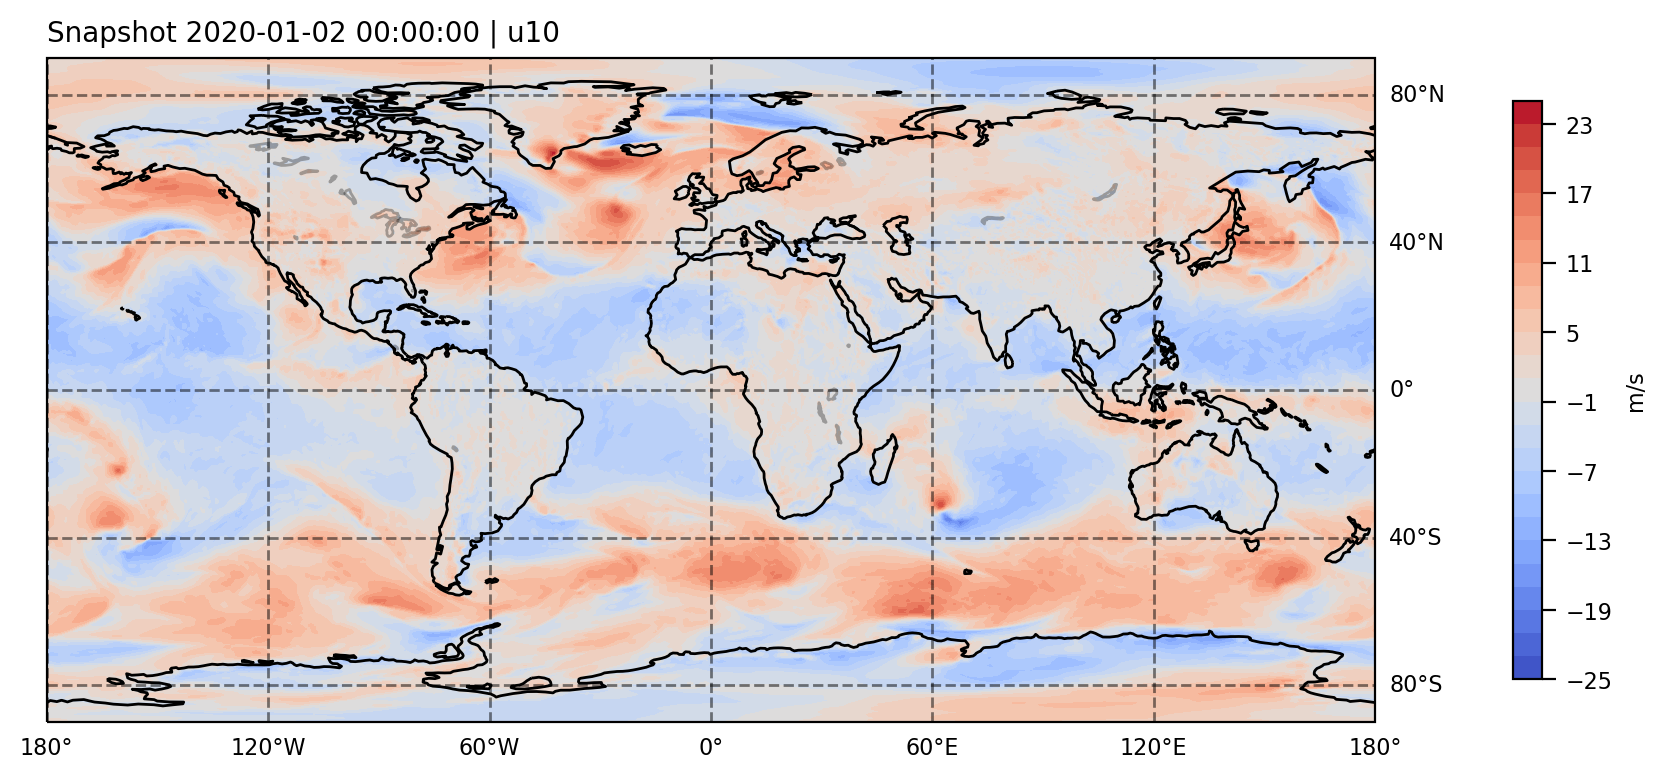

In [25]:
# Pick a day in January 2020. Just make sure you make the same format.
date_sel = datetime.datetime(2020,1,2,0) # select a desired date and hours (midnight is zero)

ERA5_snapshot= ERA5.sel(time=date_sel).load()
# we define contours levels that will be used in all plots the compare them better
colorlevels = np.arange(-25, 27, 2)

var = 'u10'
F, ax = set_projection_figure(projection = ccrs.PlateCarree(), figsize = (9, 5.5) )
ax.set_title('Snapshot '+str(date_sel) +' | '+ var , loc ='left')
dataplot = ax.contourf(ERA5_snapshot.longitude, ERA5_snapshot.latitude, ERA5_snapshot[var], levels = colorlevels, transform=ccrs.PlateCarree(), cmap= plt.cm.coolwarm)
plt.colorbar(dataplot, orientation='vertical', label = 'm/s', shrink= 0.55 , pad = 0.08)
plt.show()

Can you make plots for $v_{10}$ and $u_{speed}$ as well?

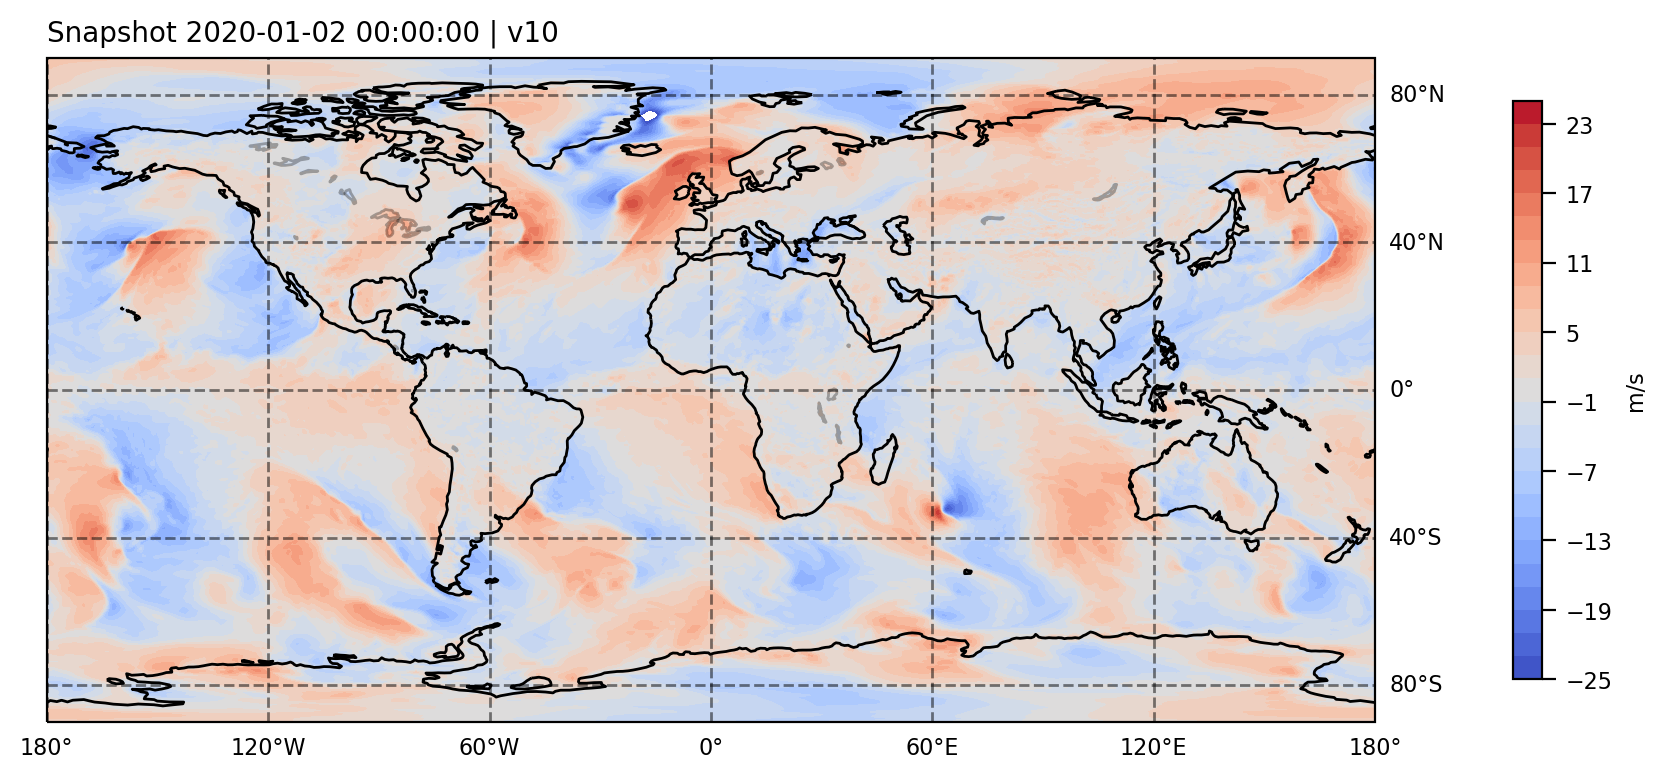

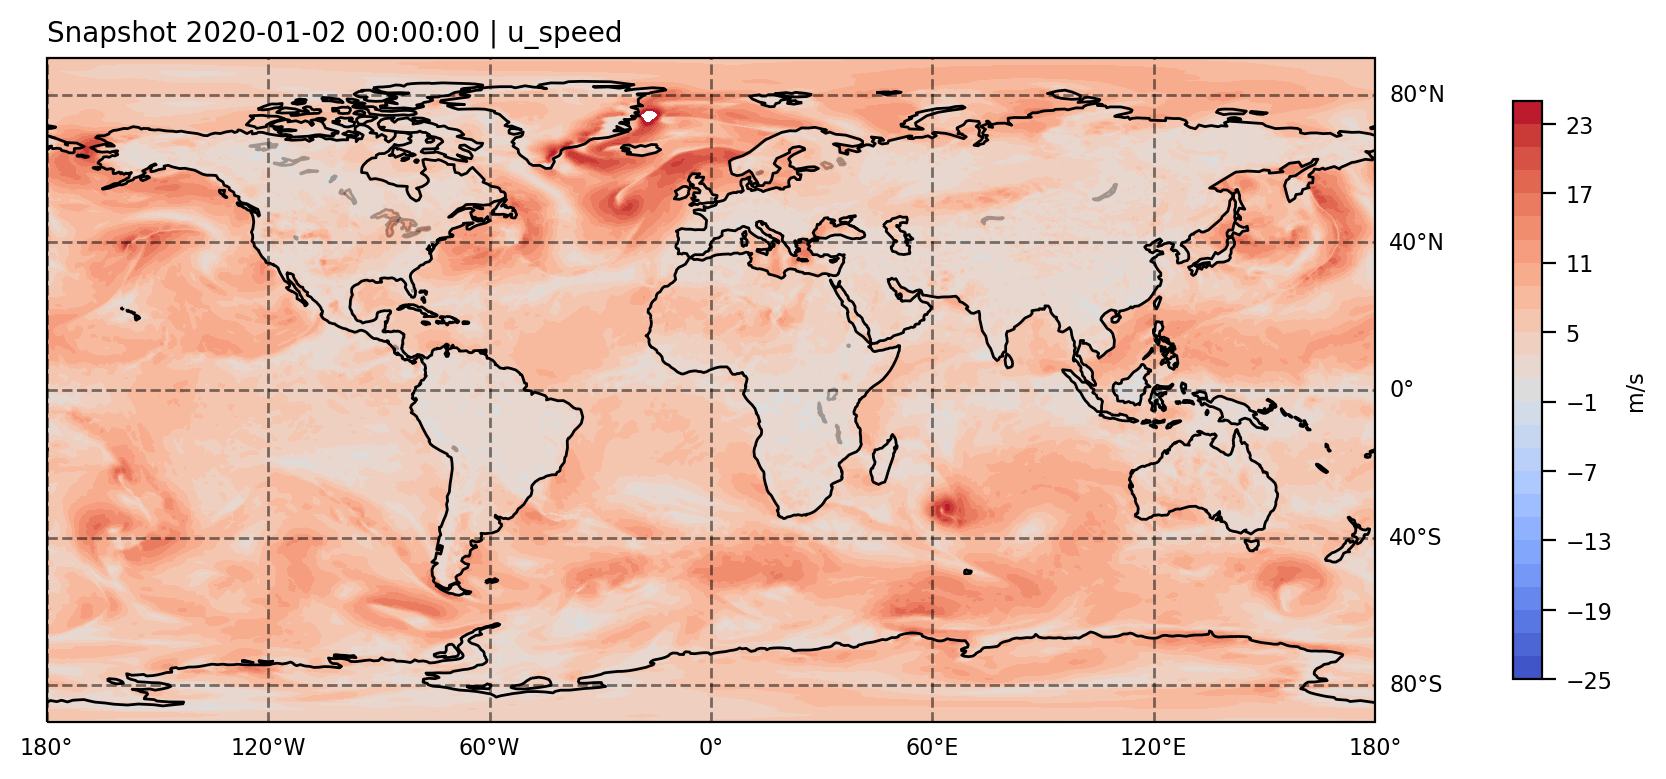

In [26]:
# answer:

# plotting v components
var = 'v10'
F, ax = set_projection_figure(projection = ccrs.PlateCarree(), figsize = (9, 5.5) )
ax.set_title('Snapshot '+str(date_sel) +' | '+ var , loc ='left')
dataplot = ax.contourf(ERA5_snapshot.longitude, ERA5_snapshot.latitude, ERA5_snapshot[var], levels = colorlevels, transform=ccrs.PlateCarree(), cmap= plt.cm.coolwarm)
plt.colorbar(dataplot, orientation='vertical', label = 'm/s', shrink= 0.55 , pad = 0.08)
plt.show()

# computing u_speed
ERA5_snapshot['u_speed'] = np.sqrt(ERA5_snapshot['u10']**2 + ERA5_snapshot['v10']**2)

# plotting u_speed components
var = 'u_speed'
F, ax = set_projection_figure(projection = ccrs.PlateCarree(), figsize = (9, 5.5) )
ax.set_title('Snapshot '+str(date_sel) +' | '+ var , loc ='left')
dataplot = ax.contourf(ERA5_snapshot.longitude, ERA5_snapshot.latitude, ERA5_snapshot[var], levels = colorlevels, transform=ccrs.PlateCarree(), cmap= plt.cm.coolwarm)
plt.colorbar(dataplot, orientation='vertical', label = 'm/s', shrink= 0.55 , pad = 0.08)
plt.show()

### *Discussion Questions:*
- What do you observe for the zonal wind component? Where do you see the strongest winds and the most variability?
- How does that compare to the meridional winds?

## Extra-tropical Storms

You see should observe in the last wind speed figure, are strong wind patches over the southern ocean, North Pacific and North Atlantic which come from strong zonal and meridional winds. These strong winds are created by extra-tropical storms. They are also known as mid-latitude cyclones and occur in the middle latitudes, between 30 and 60 degrees North or South of the equator, and are the strongest over the Southern Ocean and over Northern Hemisphere Oceans in Winter.

They are formed by the interaction of warm and cold air masses and are characterized by a low-pressure center, with winds that circulate in a counter-clockwise direction in the Northern Hemisphere and clockwise in the Southern Hemisphere. These storms can be powerful and destructive, with strong winds, heavy rain, snow, and sleet, and can cause widespread flooding, power outages, and transportation disruptions. The strength of these storms varies depending on factors such as the temperature difference between the air masses, the speed of the jet stream, and the moisture content of the air.

To learn more about extra-tropical storms, you can look at standard text books in Meteorology and Atmospheric dycnamics, or, for example here: 

https://en.wikipedia.org/wiki/Extratropical_cyclone

http://pressbooks-dev.oer.hawaii.edu/atmo/chapter/chapter-13-extratropical-cyclones/

One Storm may last for a few days and is too weak to create currents in the ocean. However continous winds andmany storms over a year will create oceancurrents as a response to the wind forcing. Now look at more data to understand these longer timescale impacts.

## Part II: Annual climatology of wind speed:

Now we will use monthly mean data because we want to look at longterm changes of wind field. 
With xarray you can derive this monthly mean data form higher-resolution data with xr.resample('1M').mean('time'). 
For convience we did that step already such that you can load the data with 

- 'si10' is the wind speed in this dataset.
- to calcualte the long-term mean we select 30 years of data, let's say 1980 to 2010:

In [27]:
url = "https://osf.io/3q4vs/download" # contains only one file: 'ERA5_surface_winds_mm.nc'
ERA5_mm=xr.open_dataset(pooch.retrieve(url, known_hash=None)).sel(time=slice('1980', '2010'))
ERA5_mm

SHA256 hash of downloaded file: 8899062c8e9ef24bcbf947e7c618aa7b4ada26b4e0fb5611d0a94850ac75f0d5
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, time: 312)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2005-12-01
Data variables:
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
    si10       (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-04-06 23:25:45 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

### *Note:*
Monthly mean ERA5 data is also avaiable through the Copernicus Portal:

[Monthly mean on single levels](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=overview), 
[Monthly mean on pressure levels](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-pressure-levels-monthly-means?tab=overview)

Let start with the climatology of zonal wind

In [28]:
ERA5_ANN = ERA5_mm.mean('time')

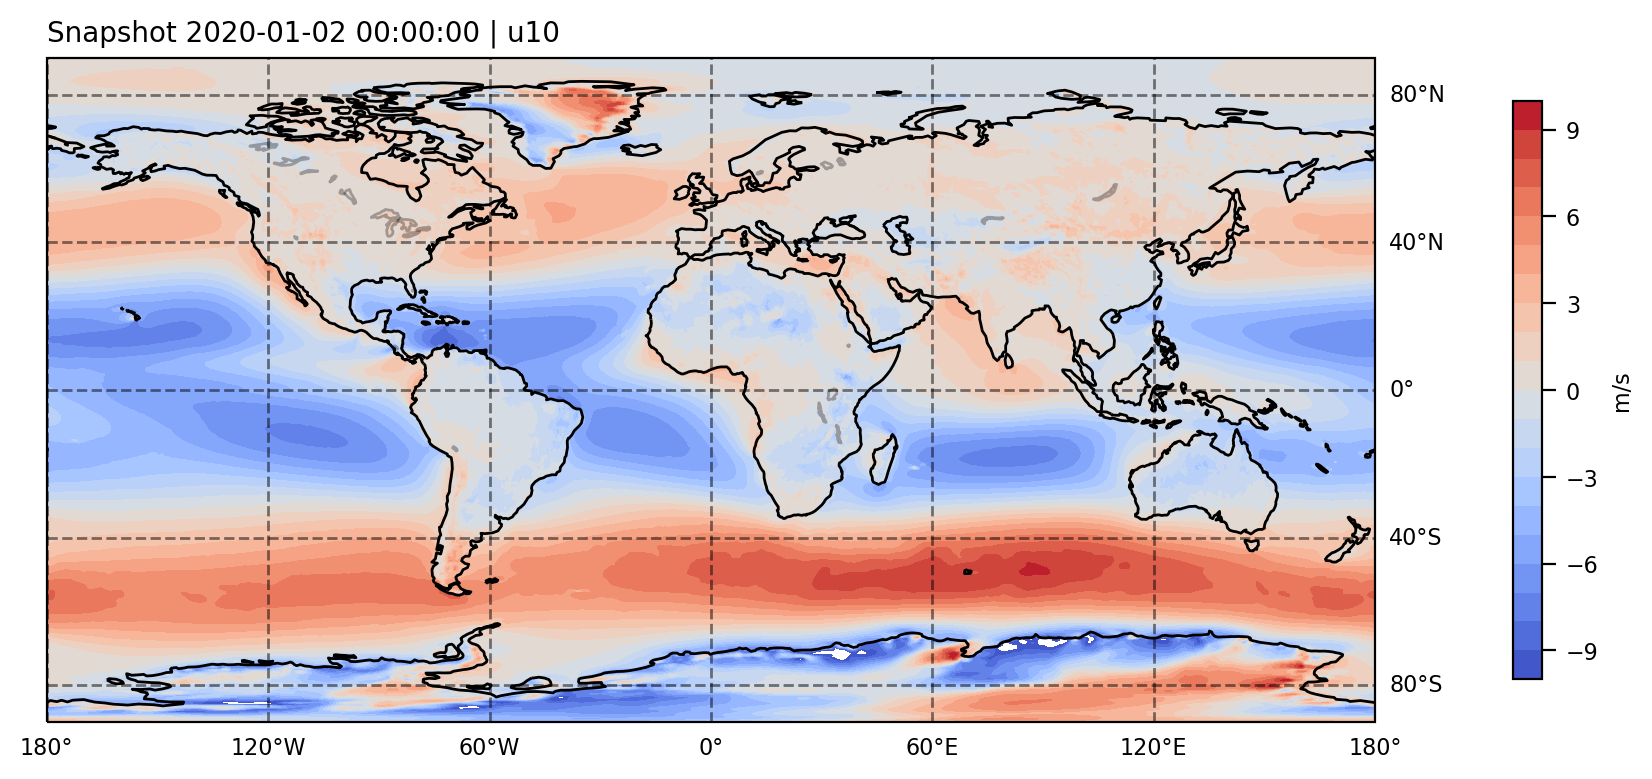

In [30]:
# adjust colorlevels to weaker amplitudes
colorlevels_clim = np.arange(-10, 11, 1)

var = 'u10'
F, ax = set_projection_figure(projection = ccrs.PlateCarree(), figsize = (9, 5.5) )
ax.set_title('Snapshot '+str(date_sel) +' | '+ var , loc ='left')
dataplot = ax.contourf(ERA5_ANN.longitude, ERA5_ANN.latitude, ERA5_ANN[var],
                       levels = colorlevels_clim,
                       transform=ccrs.PlateCarree(), cmap= plt.cm.coolwarm)
plt.colorbar(dataplot, orientation='vertical', label = 'm/s', shrink= 0.55 , pad = 0.08)
plt.show()

You see two strong wind bands between 35 to 65 degrees North or South, which are the so called *westerlies* in the mid-latitudes. Then you also see dominantly *easterly* winds in the tropic ($< 30^\circ$ N/S). 
These two wind regimes, one in the tropics and one in the extra-tropics, are weirdly linked through the so-called large-scale circulation of the atmosphere. This circulation is often described as 3-cell struture, which you see here:
    
![948px-Earth_Global_Circulation_-_en.svg.png](attachment:ff181dda-cb5d-4e71-b48d-59807d848c81.png)
    
https://commons.wikimedia.org/wiki/File:Earth_Global_Circulation_-_en.svg
   
These large-scale circulation are a major contributer to the climate we expierene in differnent lattitudes. 

*Discussion questions:*
- 1. Which of the three "cells" (Hadley Cell, Farrell Cell, and Polar Cell) in the figure belong to the zonal wind band that we plotted above?

The circulation cells in the schematic also show a meridional (north-south) component of the surface winds, but we onnly plotted the zonal wind climatology. Let's also make the meridional wind climatology and see how that looks like:

In [ ]:
# put code here

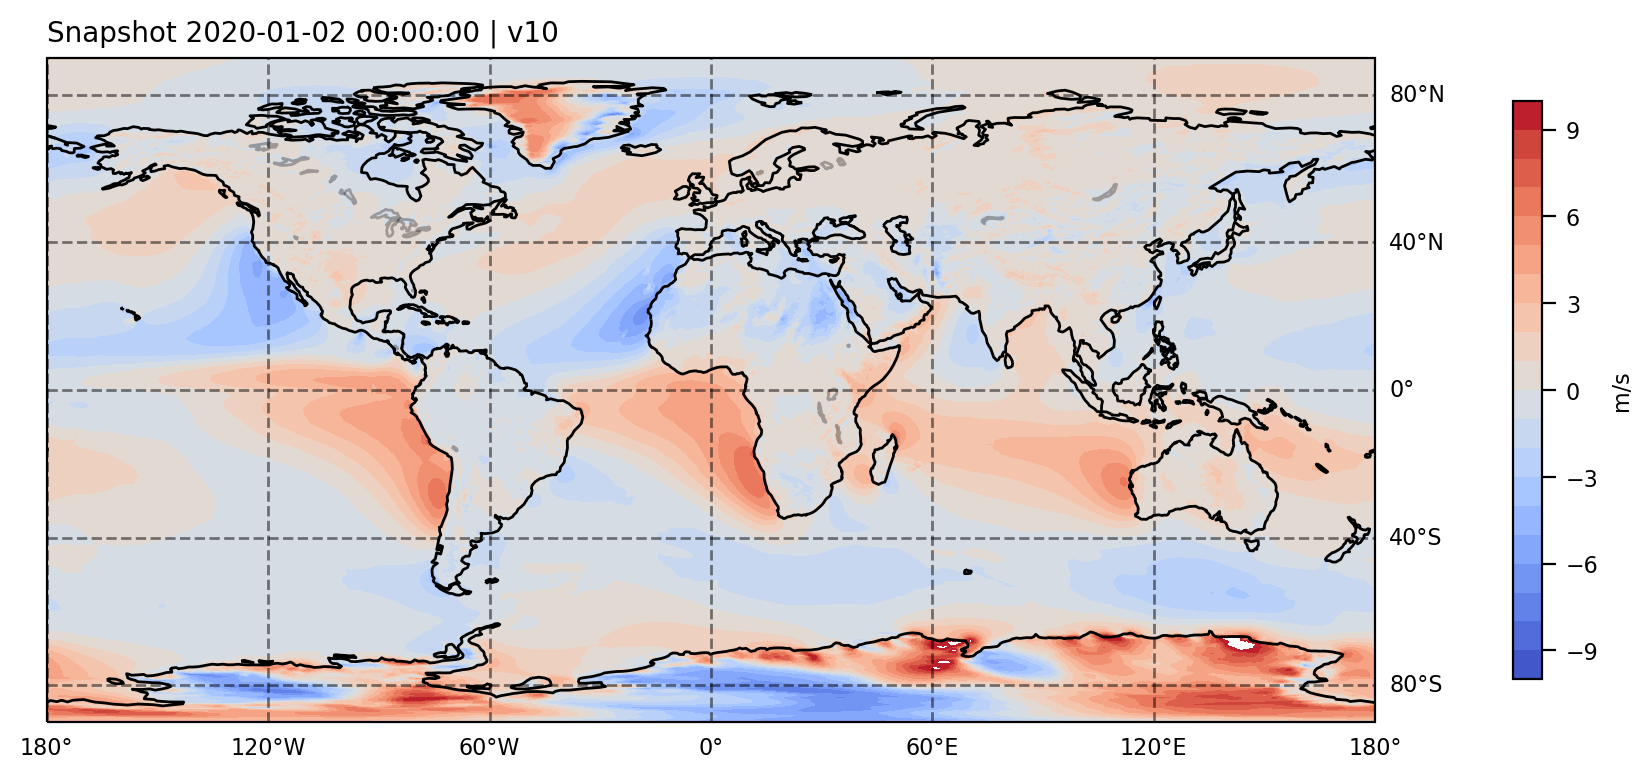

In [32]:
# answer:
var = 'v10'
F, ax = set_projection_figure(projection = ccrs.PlateCarree(), figsize = (9, 5.5) )
ax.set_title('Snapshot '+str(date_sel) +' | '+ var , loc ='left')
dataplot = ax.contourf(ERA5_ANN.longitude, ERA5_ANN.latitude, ERA5_ANN[var],
                       levels = colorlevels_clim,
                       transform=ccrs.PlateCarree(), cmap= plt.cm.coolwarm)
plt.colorbar(dataplot, orientation='vertical', label = 'm/s', shrink= 0.55 , pad = 0.08)
plt.show()

You see the are strong southward winds in the Northern Hemisphere subtropic (blue) and northward wind in the Southern hemisphere, also in the subtropic. What else do you see when you compare the zonal with the meridional wind climatology?

### Answer:
The meridional winds seam to be strongest on the western side of the continents. 
The reasons for that are hard to explain here, but want to look at their overall effect. For that, we can plot the zonal mean of the zonal and meridional winds:

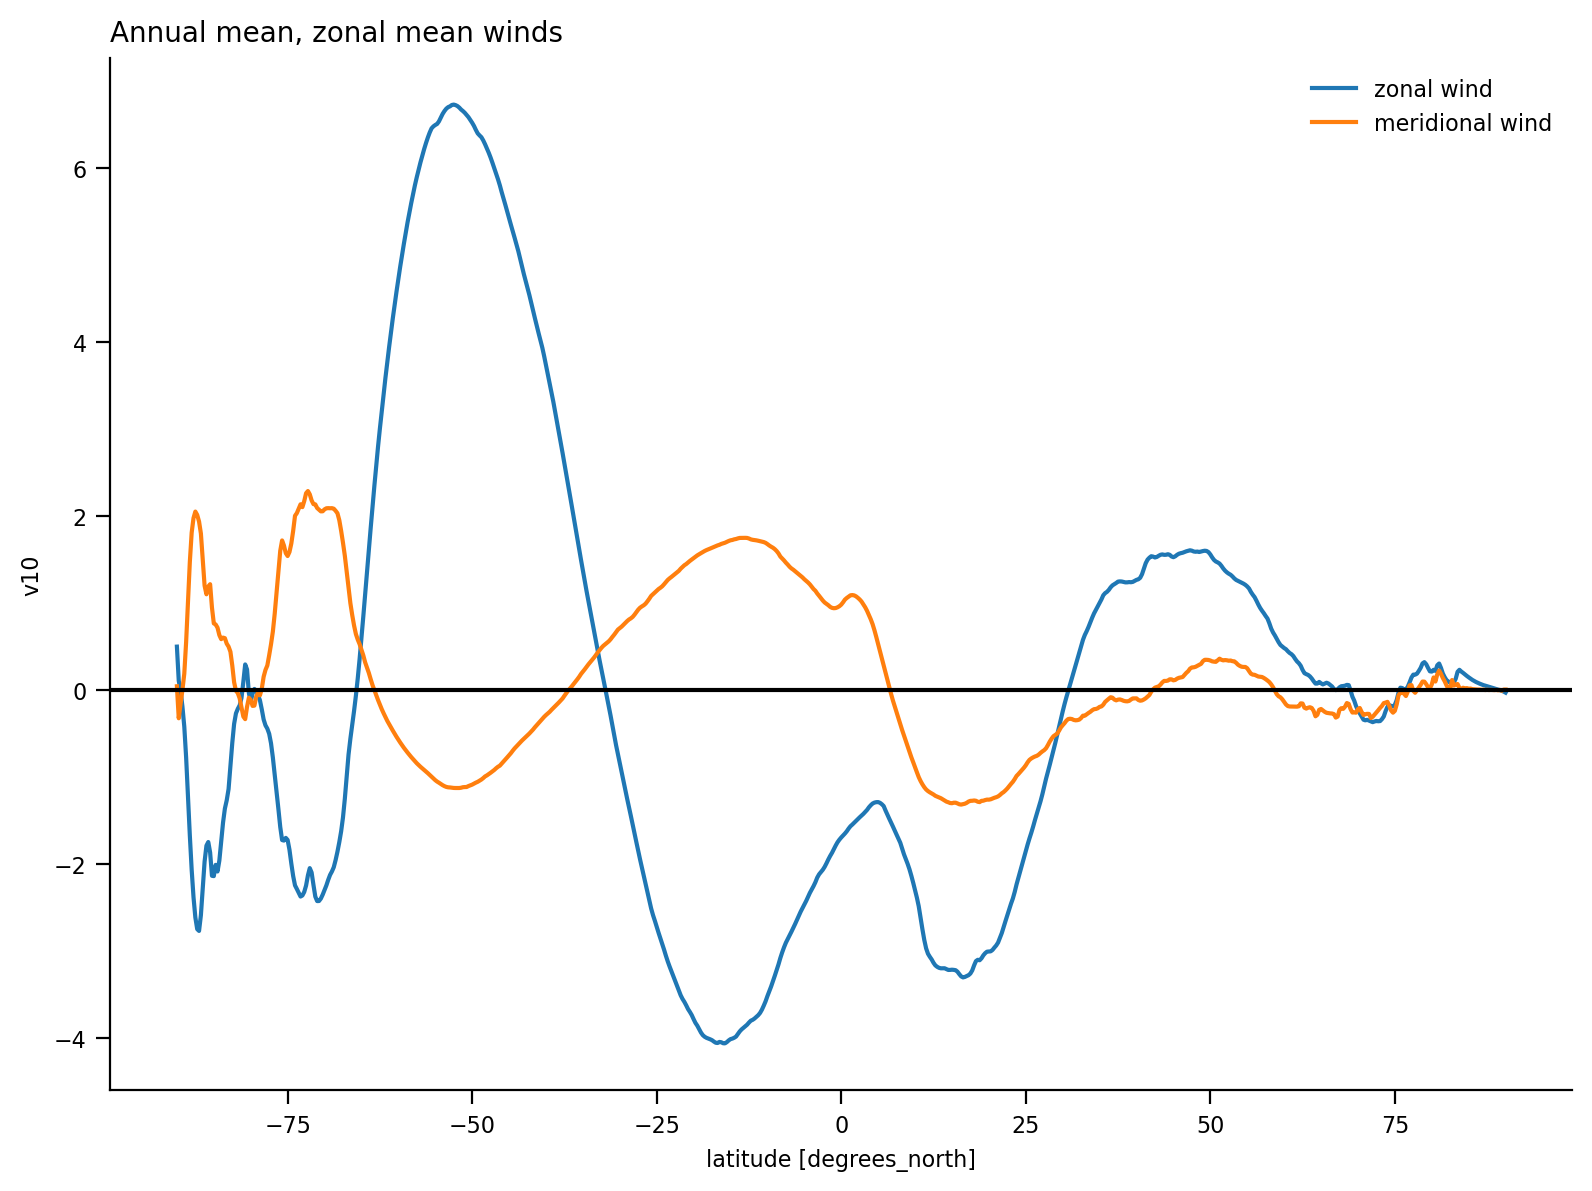

In [33]:
ERA5_ANN.mean('longitude')['u10'].plot(label = 'zonal wind')
ERA5_ANN.mean('longitude')['v10'].plot(label = 'meridional wind')
plt.legend()
plt.title('Annual mean, zonal mean winds', loc= 'left' )
ax = plt.gca()
ax.axhline(0, color = 'black')

### *Questions:*
- With the figure above in mind, why do you see these large differences in the nothern and Southern Hemisphere?

### Answer:

The continents influence the strength of the winds, and since the continents are so unevenly positioned on on the planet, the winds are weaker in the North then in the South. The strongest winds occur in the Southenr Ocean, where we nearly ahve no continents, and the winds must get very strong to create the same amount of drag as over the large land masses in the Northern Hemisphere.

## Part III: Seasonal Climatology

Lets finalluy look at how the zonal mean winds change with season. We do that here for zonal and meridional winds seperatly.
Let start with the zonal component. For that we create a so-called Hoffmöller diagram, that has latitude on the horizonal axis and time in the vertical axis.
That will show us how the zonal mean winds differ with season and how the seasons differ over the years:


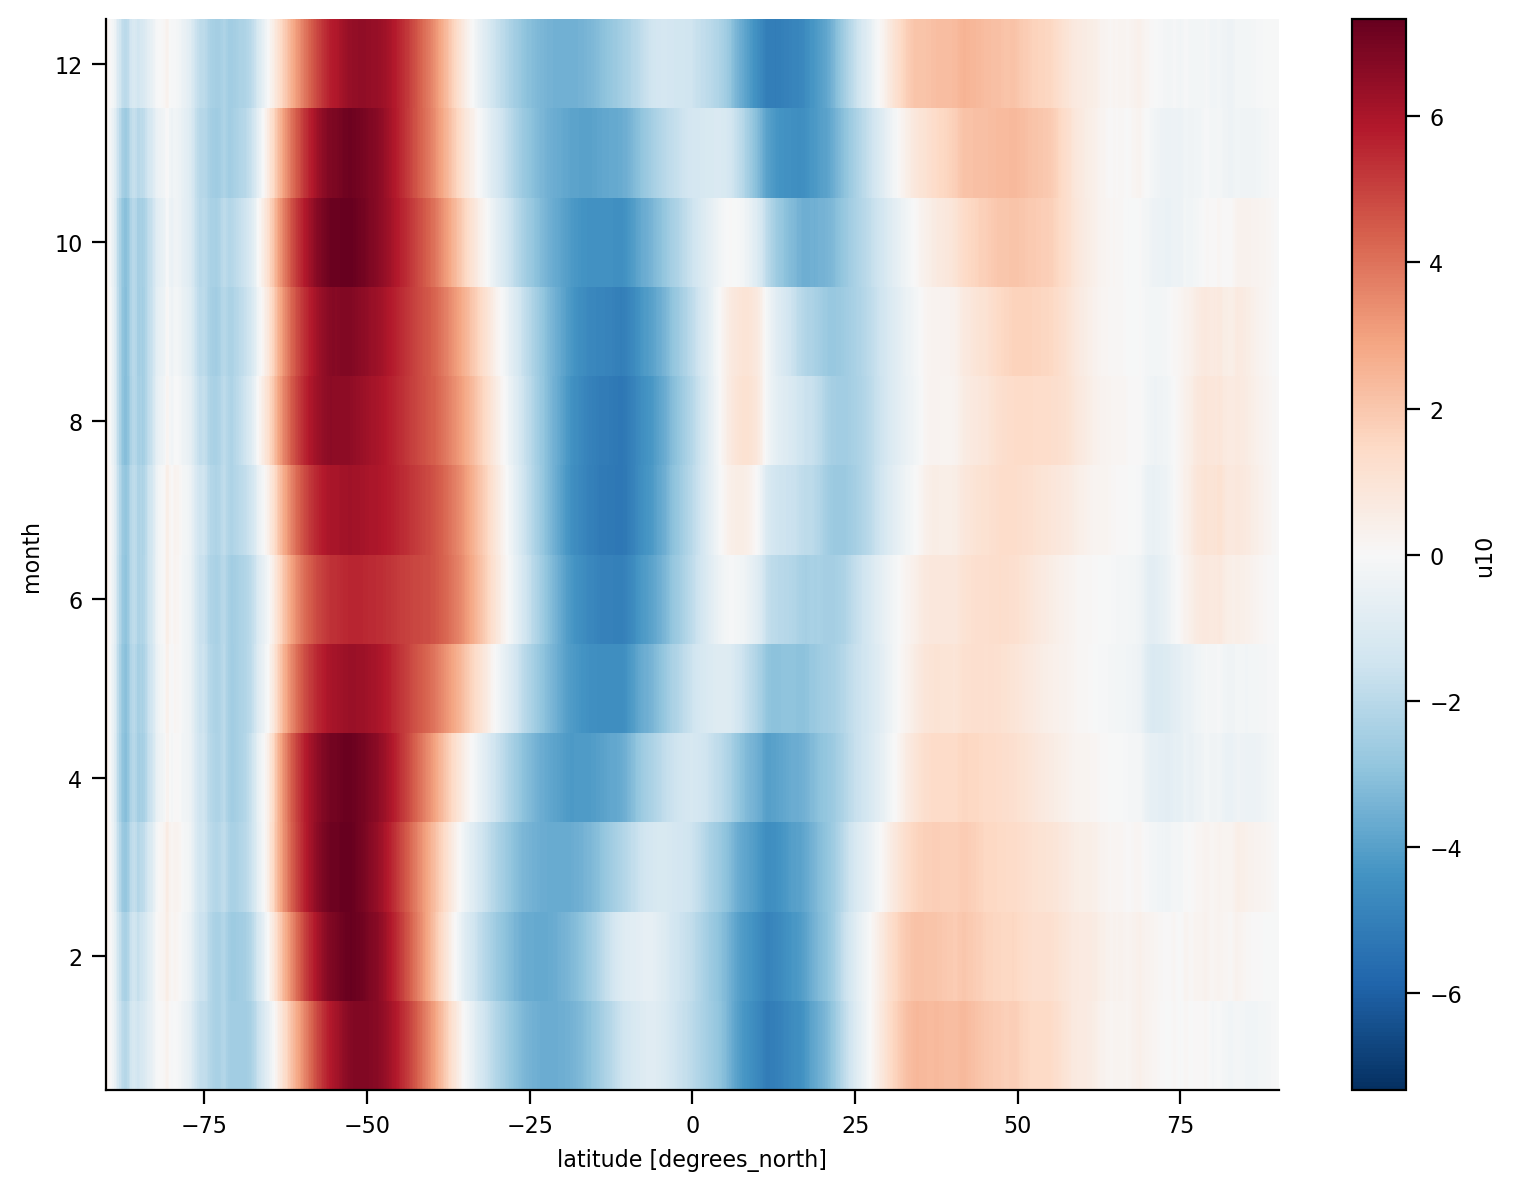

In [34]:
# the groupby command regroups the data by month, such that all Januarys, all Februaries, .. and so on are taken the mean over
ERA5_mm.mean('longitude')['u10'].groupby('time.month').mean().plot()

### *Task:*

Now its on you to make the same disagram for the meridinal winds:
    

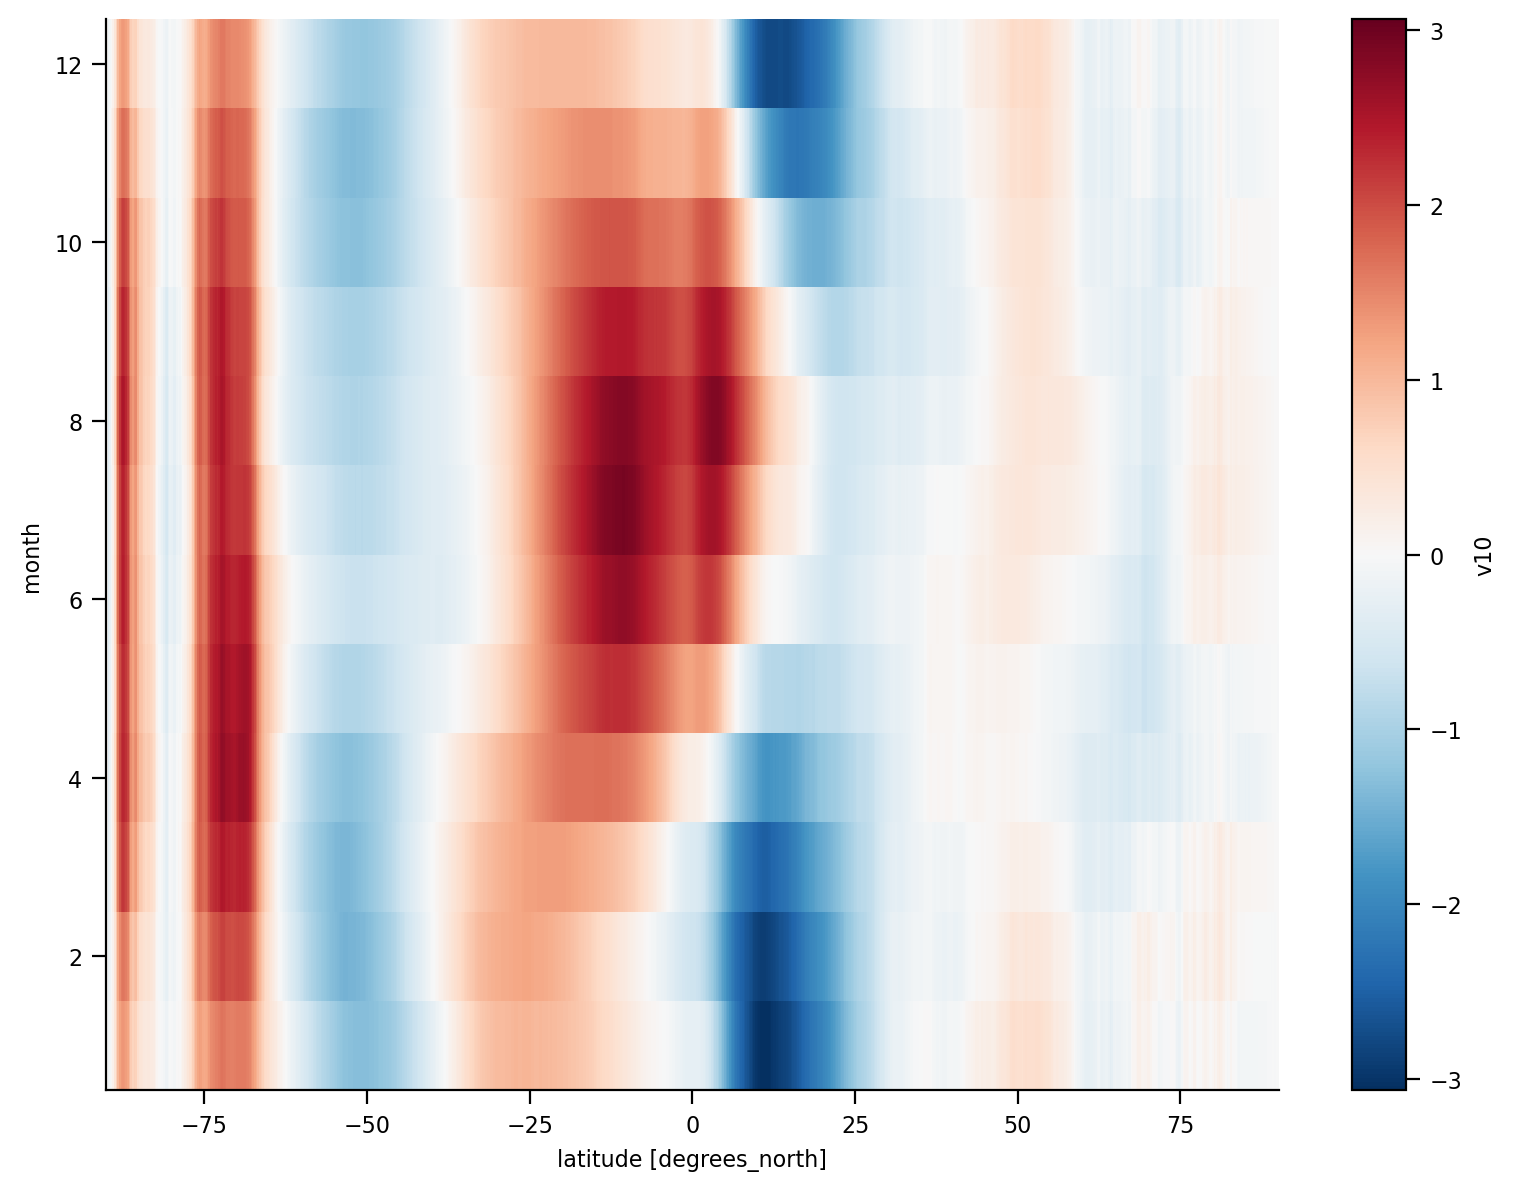

In [35]:
ERA5_mm.mean('longitude')['v10'].groupby('time.month').mean().plot()

#### *A few note:*
- The winds in the Southern Hemisphere seam to be generally stronger then in the Northern Hemisphere.
- The strong meridional winds between June and September come from the variation if the Hadley cell with season. 
The Hadley cell in the repspective winter hemisphers is much stronger.
- the zonal winds are about twice as astrong as the meridional component (look at the colorbars). Does that align with the Cell structure shown above?

---
# Summary

In this Tutorial you learned about about the atmopsheric circulation by just analysing at surface winds. By using the ERA5 reanlysis you now have a basic understanding of 

- the westerlies and Easterlies on the globe, how they vary with season, and that they are statistics over many individual storms that can create strong winds locally.
- You observed that the strongest winds appear over the Southern Ocean.

You learned 
- how to make climatology over different dimensions of the dataset, and
- how to regroup ata by a timestamp, in this case month.


### Bonus:

- plot the global map for DJF and JJA of the zonal wind. What do you see when you compare the mid-latitudes? (you can also plot their differnce(!)

- plot trend of the zonal mean zonal wind in DJF


That is because the solar insulation leads to varying circulation patterns with seasons. 
More about this you can find in [Global Physical Climatology](https://www.atmos.washington.edu/~dennis/gpc.html), 
[The Atmospheric General Circulation](https://www.cambridge.org/us/academic/subjects/earth-and-environmental-science/atmospheric-science-and-meteorology/atmospheric-general-circulation?format=HB&isbn=9781108474245)
or the first few chapters of this evolving draft [Physics of Earth's Climate](https://climate-dynamics.org/wp-content/uploads/2017/04/Climate_Book.pdf)


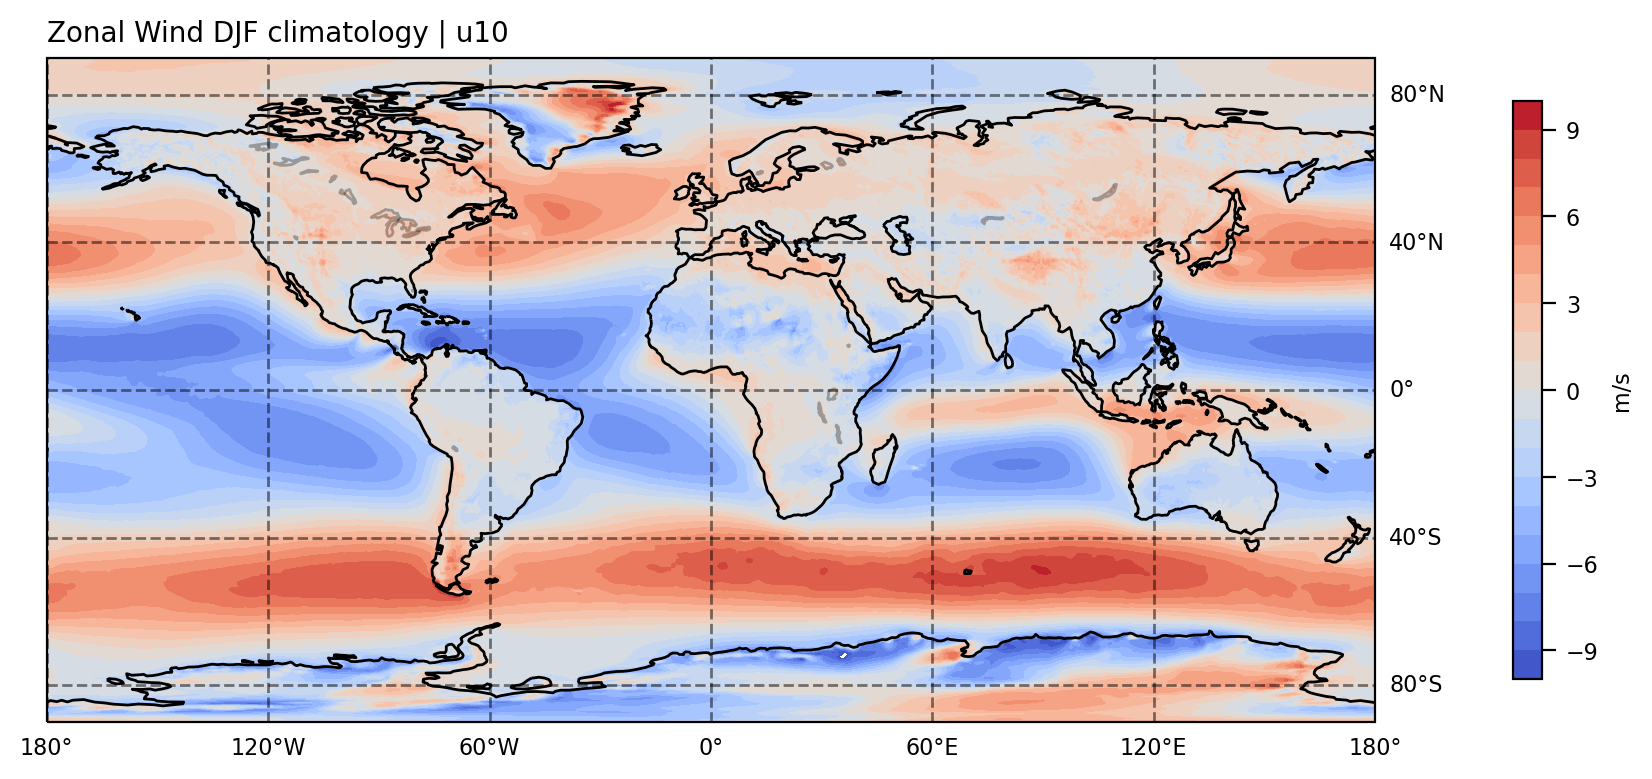

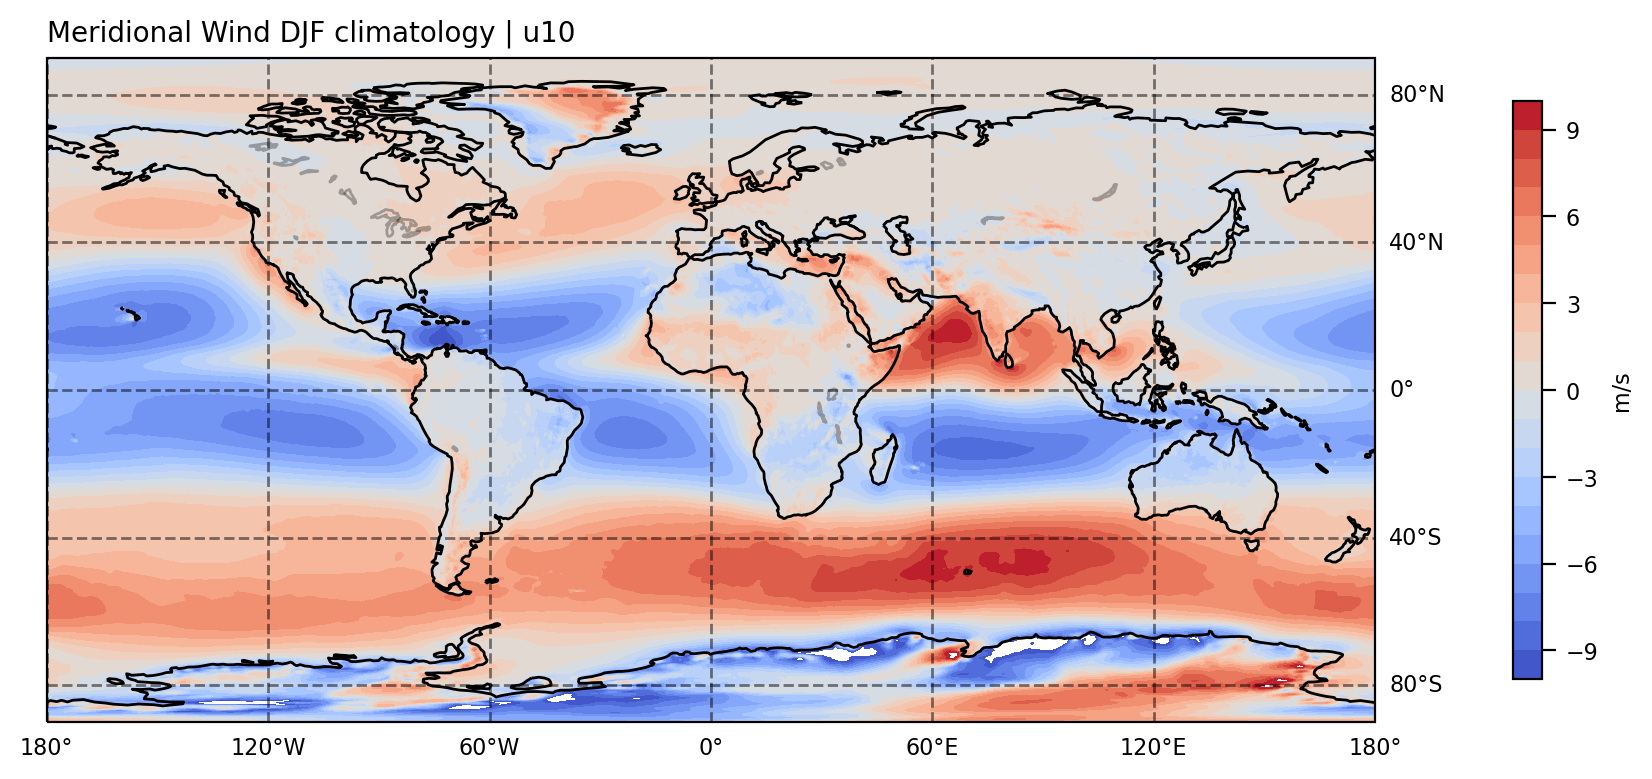

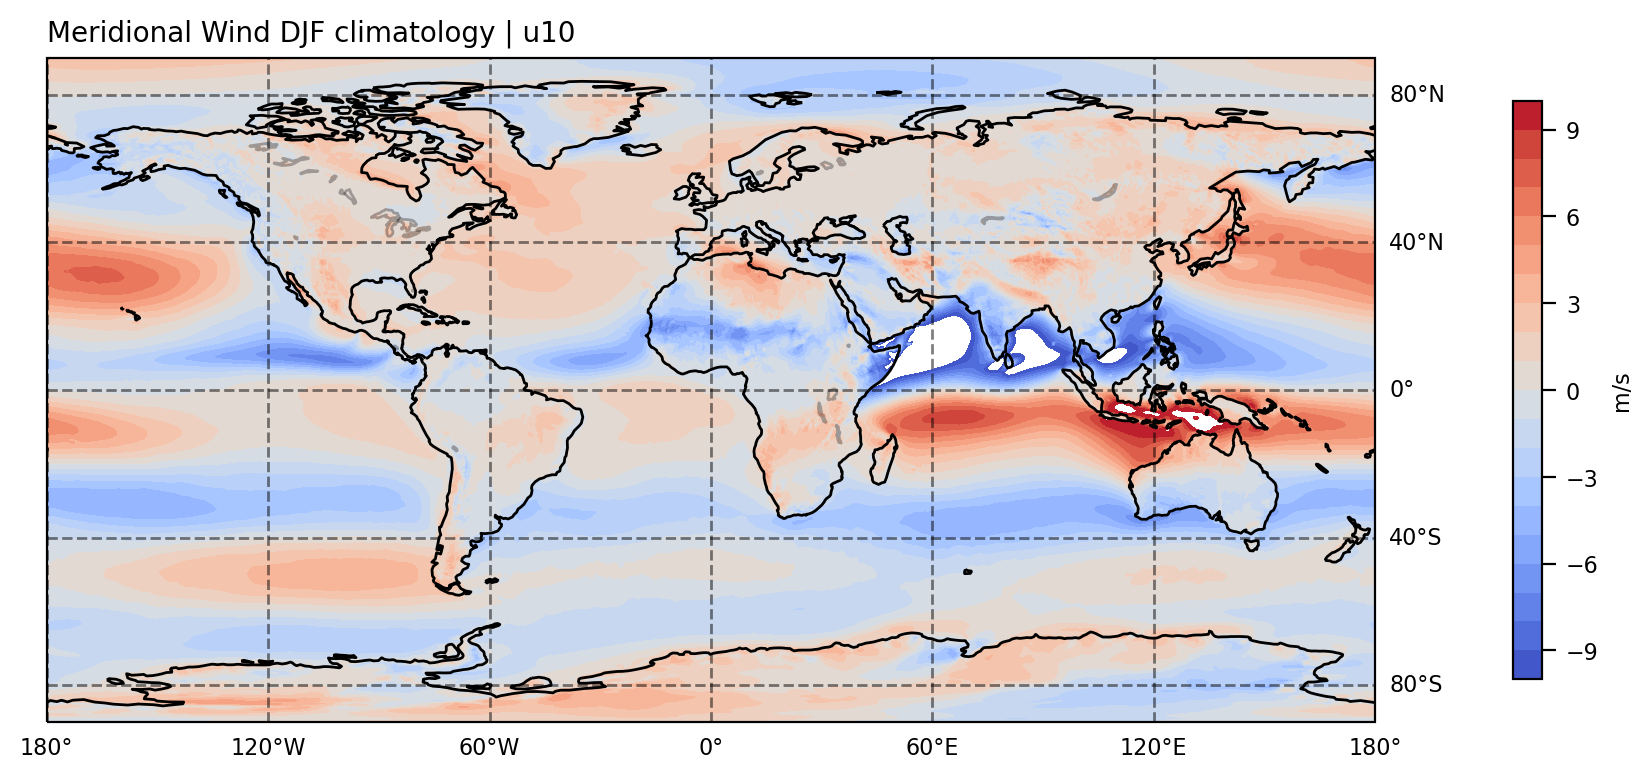

In [36]:
# answer:
ERA5_season = ERA5_mm.groupby('time.season').mean()

var='u10'
season='DJF'
F, ax = set_projection_figure(projection = ccrs.PlateCarree(), figsize = (9, 5.5) )
ax.set_title('Zonal Wind DJF climatology | '+ var , loc ='left')
dataplot = ax.contourf(ERA5_season.longitude, ERA5_season.latitude, ERA5_season.sel(season=season)[var],
                       levels = colorlevels_clim,
                       transform=ccrs.PlateCarree(), cmap= plt.cm.coolwarm)
plt.colorbar(dataplot, orientation='vertical', label = 'm/s', shrink= 0.55 , pad = 0.08)
plt.show()


var='u10'
season='JJA'
F, ax = set_projection_figure(projection = ccrs.PlateCarree(), figsize = (9, 5.5) )
ax.set_title('Meridional Wind DJF climatology | '+ var , loc ='left')
dataplot = ax.contourf(ERA5_season.longitude, ERA5_season.latitude, ERA5_season.sel(season=season)[var],
                       levels = colorlevels_clim,
                       transform=ccrs.PlateCarree(), cmap= plt.cm.coolwarm)
plt.colorbar(dataplot, orientation='vertical', label = 'm/s', shrink= 0.55 , pad = 0.08)
plt.show()

# difference:
var='u10'
pdata =ERA5_season.sel(season='DJF')[var] - ERA5_season.sel(season='JJA')[var]

F, ax = set_projection_figure(projection = ccrs.PlateCarree(), figsize = (9, 5.5) )
ax.set_title('Meridional Wind DJF climatology | '+ var , loc ='left')
dataplot = ax.contourf(ERA5_season.longitude, ERA5_season.latitude,pdata ,
                       levels = colorlevels_clim,
                       transform=ccrs.PlateCarree(), cmap= plt.cm.coolwarm)
plt.colorbar(dataplot, orientation='vertical', label = 'm/s', shrink= 0.55 , pad = 0.08)
plt.show()